# Capstone Project - The Battle of Neighborhoods

### Introduction

In this project I have explored different venues in the New York city.  With almost 20 million people in its metropolitan statistical area and approximately 23 million in its combined statistical area, it is one of the world's most populous megacities.  New York City has been described as the cultural, financial, and media capital of the world, significantly influencing commerce, entertainment, research, technology, education, politics, tourism, art, fashion, and sports. 

As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. New York is home to more than 3.2 million residents born outside the United States, the largest foreign-born population of any city in the world as of 2016.

With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , Indian , Italian etc.

So as part of this project , we will list and visualize all major parts of New York City that has great Indian resturants.

Also we would try to find answers to the following questions-

- What is best location in New York City for Indian Cuisine ? 
- Which areas have potential Indian Resturant Market ? 
- Which all areas lack Indian Resturants ?
- Which is the best place to stay if I prefer Indian Cuisine ?

### Data 
For this project we need the following data :
<ul>
<li> New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
    <ul>
        <li>Data source : https://cocl.us/new_york_dataset
        <li> Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.
     </ul>
<li> Indian resturants in each neighborhood of new york city.
        <ul>
        <li>Data source : Fousquare API
        <li> Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only indian resturants.
     </ul>
<li> GeoSpace data
          <ul>
        <li>Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
        <li> Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.
  
</ul>

### Approach
- Collect the new york city data from https://cocl.us/new_york_dataset
- Using FourSquare API we will find all venues for each neighborhood.
- Filter out all venues that are Japanese Resturants.
- Find rating , tips and like count for each Japanese Resturants using FourSquare API.
- Using rating for each resturant , we will sort that data.
- Visualize the Ranking of neighborhoods using folium library(python)

### Analysis

We will import the required libraries for python.

- pandas and numpy for handling data.
- request module for using FourSquare API.
- geopy to get co-ordinates of City of New York.
- folium to visualize the results on a map

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 
import os
import folium # map rendering library
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Pradhan\Anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0




geographiclib-1.50   | 34 KB     |            |   0% 
geographiclib-1.50   | 34 KB     | ####7      |  47% 
geographiclib-1.50   | 34 KB     | ########## | 100% 

geopy-1.22.0         | 63 KB     |            |   0% 
geopy-1.22.0     

Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given  latitude and longitude. Below function will return us the venue id , venue name and category.

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100


    CLIENT_ID = 'R01LINGO2WC45KLRLKT3ZHU2QENAO2IPRK2N2ELOHRNK4P3K' # your Foursquare ID
    CLIENT_SECRET = '4JT1TWRMXMPLX5IOKNBAFU3L3ARXK4D5JJDPFK1CLRZM2ZVW' # your Foursquare Secret

    VERSION = '20180604'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
    

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id.
This will be used for ranking.

In [4]:
def get_venue_details(venue_id):
        


    CLIENT_ID = 'R01LINGO2WC45KLRLKT3ZHU2QENAO2IPRK2N2ELOHRNK4P3K' # your Foursquare ID
    CLIENT_SECRET = '4JT1TWRMXMPLX5IOKNBAFU3L3ARXK4D5JJDPFK1CLRZM2ZVW' # your Foursquare Secret

    VERSION = '20180604'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [6]:
# get new york data
new_york_data=get_new_york_data()

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York

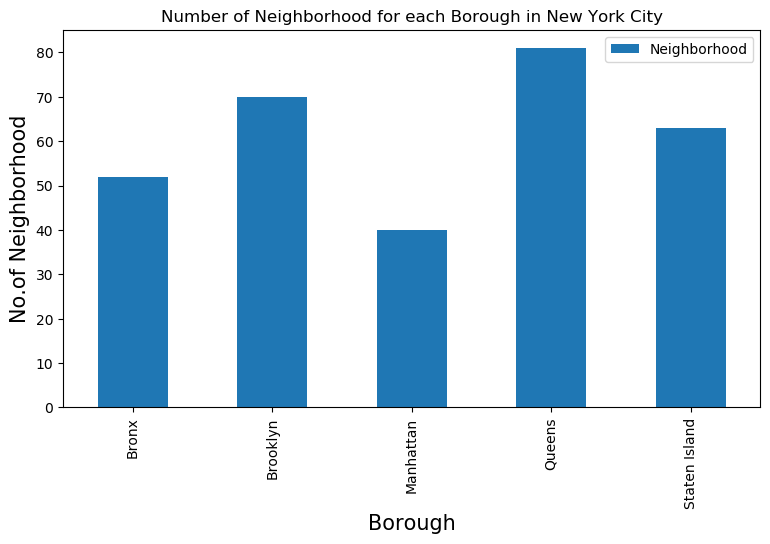

In [9]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will collect Indian resturants for each Neighborhood

In [11]:
# prepare neighborhood list that contains japanese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_resturants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Japanese Resturants in '+Neighborhood+', '+Borough+':'+str(len(japanese_resturants)))
    for resturant_detail in japanese_resturants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1


( 1 / 306 ) Japanese Resturants in Wakefield, Bronx:0
( 2 / 306 ) Japanese Resturants in Co-op City, Bronx:0
( 3 / 306 ) Japanese Resturants in Eastchester, Bronx:0
( 4 / 306 ) Japanese Resturants in Fieldston, Bronx:0
( 5 / 306 ) Japanese Resturants in Riverdale, Bronx:2
( 6 / 306 ) Japanese Resturants in Kingsbridge, Bronx:2
( 7 / 306 ) Japanese Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Japanese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Japanese Resturants in Norwood, Bronx:0
( 10 / 306 ) Japanese Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Japanese Resturants in Baychester, Bronx:0
( 12 / 306 ) Japanese Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Japanese Resturants in City Island, Bronx:1
( 14 / 306 ) Japanese Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Japanese Resturants in University Heights, Bronx:0
( 16 / 306 ) Japanese Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Japanese Resturants in Fordham, Bronx:0
( 18 / 306 ) Japanese Resturants in Ea

Now that we have got all the indian resturants in new york city , we will analyze it

In [12]:
japanese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse


In [13]:
japanese_rest_ny.shape

(181, 4)

We got 181 Indian Resturants across New York City

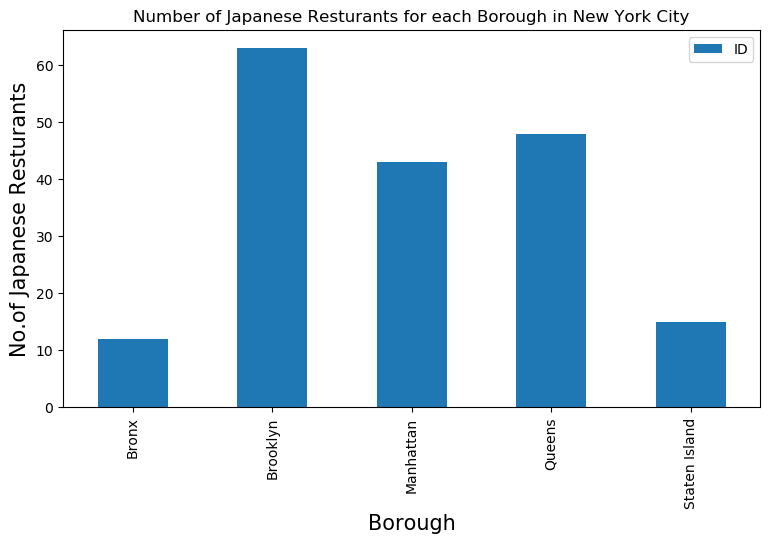

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Japanese Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Japanese Resturants', fontsize=15)
#giving a bar plot
japanese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Brooklyn has the largest number of indian resturants

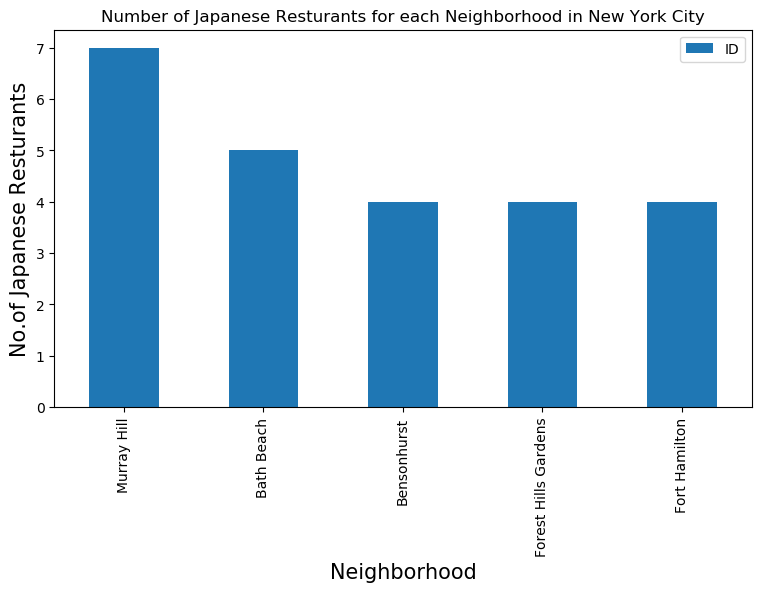

In [16]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Japanese Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Japanese Resturants', fontsize=15)
#giving a bar plot
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [18]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
77,Manhattan,Murray Hill,4a99b4f4f964a520f62f20e3,Kajitsu
78,Manhattan,Murray Hill,591caee89deb7d0f69be77a2,Omusubi Gonbei
79,Manhattan,Murray Hill,49db8b67f964a520d85e1fe3,Aburiya Kinnosuke
80,Manhattan,Murray Hill,51e8ce40498ea1fb0180efb2,Izakaya MEW
114,Queens,Murray Hill,4bc8eee83740b713fcbe5d65,Northern Sushi
115,Queens,Murray Hill,5cf07afa66f3cd002c8b3ae6,Izakaya Mew
116,Queens,Murray Hill,4bfdd6ab4cf820a1fd21edf4,Kan


So Floral Park in Queens has the highest number of Indian Resturants with a total count of 7.

Now we will get the ranking of each resturant for further analysis.

In [19]:
# prepare neighborhood list that contains japanese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(japanese_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1


                         ID                      Name  Likes  Rating  Tips
0  503cfaffe4b066d39de5005a  Aoyu Japanese Restaurant     32     8.8    19
( 1 / 181 ) processed
                         ID             Name  Likes  Rating  Tips
0  4b0b311af964a520642e23e3  Palace of Japan     38     8.6    26
( 2 / 181 ) processed
                         ID                      Name  Likes  Rating  Tips
0  503cfaffe4b066d39de5005a  Aoyu Japanese Restaurant     32     8.8    19
( 3 / 181 ) processed
                         ID             Name  Likes  Rating  Tips
0  4b0b311af964a520642e23e3  Palace of Japan     38     8.6    26
( 4 / 181 ) processed
                         ID                                         Name  \
0  4dbdf3d790a02849cbd675be  Ohana Japanese Habachi Seafood & Steakhouse   

   Likes  Rating  Tips  
0     34     7.4    18  
( 5 / 181 ) processed
                         ID      Name  Likes  Rating  Tips
0  5d40d7a398a00a0008b4c8ca  Benihana      0     7.6     0
( 6 /

In [20]:
japanese_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,8.8,19
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan,38,8.6,26
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,8.8,19
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan,38,8.6,26
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse,34,7.4,18


In [21]:
japanese_rest_stats_ny.shape

(181, 7)

In [22]:
japanese_rest_ny.shape

(181, 4)

In [25]:
# Taken a backup in a different dataframe
#japanese_rest_stats_ny_backup = japanese_rest_stats_ny

In [26]:
japanese_rest_stats_ny.to_csv('japanese_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file

In [31]:
japanese_rest_stats_ny_backup.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,8.8,19
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan,38,8.6,26
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,8.8,19
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan,38,8.6,26
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse,34,7.4,18


In [32]:
japanese_rest_stats_ny_backup.shape

(181, 7)

In [34]:
japanese_rest_stats_ny['Likes']=japanese_rest_stats_ny['Likes'].astype('float64')
japanese_rest_stats_ny['Tips']=japanese_rest_stats_ny['Tips'].astype('float64')

In [35]:
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 7 columns):
Borough         181 non-null object
Neighborhood    181 non-null object
ID              181 non-null object
Name            181 non-null object
Likes           181 non-null float64
Rating          181 non-null float64
Tips            181 non-null float64
dtypes: float64(3), object(4)
memory usage: 10.0+ KB


Now the data types looks correct

In [37]:
# Resturant with maximum Likes
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              51e8ce40498ea1fb0180efb2
Name                         Izakaya MEW
Likes                               1055
Rating                               8.8
Tips                                 267
Name: 76, dtype: object

In [38]:
# Resturant with maximum Rating
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood           East Williamsburg
ID              52517e05498ec2e28c792fa2
Name               Brooklyn Ball Factory
Likes                                298
Rating                               9.3
Tips                                  89
Name: 57, dtype: object

In [39]:
# Resturant with maximum Tips
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              51e8ce40498ea1fb0180efb2
Name                         Izakaya MEW
Likes                               1055
Rating                               8.8
Tips                                 267
Name: 76, dtype: object

Lets analyse average rating of the neighborhood

In [42]:
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [43]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False)

,Neighborhood,Average Rating
65,Lower East Side,9.200000
96,Stuyvesant Town,9.200000
77,Noho,9.175000
19,Cobble Hill,9.100000
28,East Village,9.100000
32,Flatiron,9.033333
83,Prospect Heights,9.000000
29,East Williamsburg,9.000000
42,Gramercy,8.900000
62,Lindenwood,8.900000


In [64]:
ny_borough_stats=japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [65]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.646512
1,Brooklyn,7.303175
3,Queens,7.045833
4,Staten Island,6.733333
0,Bronx,6.250000


Similarly these are the average rating of Indian Resturants for each Borough

Lets visualize it

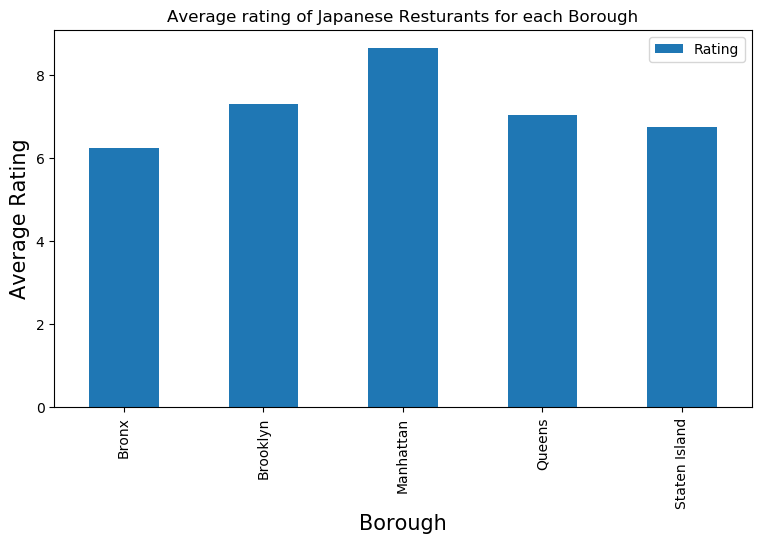

In [66]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Japanese Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [86]:
ny_neighborhood_stats_9=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9]

In [87]:
ny_neighborhood_stats_9

,Neighborhood,Average Rating
19,Cobble Hill,9.100000
28,East Village,9.100000
29,East Williamsburg,9.000000
32,Flatiron,9.033333
65,Lower East Side,9.200000
77,Noho,9.175000
83,Prospect Heights,9.000000
96,Stuyvesant Town,9.200000


We will join this dataset to original new york data to get lonitude and latitude

In [88]:
ny_neighborhood_stats_9=pd.merge(ny_neighborhood_stats_9,new_york_data, on='Neighborhood')

In [90]:
ny_neighborhood_stats_9=ny_neighborhood_stats_9[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [91]:
ny_neighborhood_stats_9

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Cobble Hill,40.687920,-73.998561,9.100000
1,Manhattan,East Village,40.727847,-73.982226,9.100000
2,Brooklyn,East Williamsburg,40.708492,-73.938858,9.000000
3,Manhattan,Flatiron,40.739673,-73.990947,9.033333
4,Manhattan,Lower East Side,40.717807,-73.980890,9.200000
5,Manhattan,Noho,40.723259,-73.988434,9.175000
6,Brooklyn,Prospect Heights,40.676822,-73.964859,9.000000
7,Manhattan,Stuyvesant Town,40.731000,-73.974052,9.200000


Now we will show this data on a map

In [111]:
# create map
map_clusters = folium.Map(geo_location('New York'), zoom_start=12)



# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_neighborhood_stats_9['Latitude'], ny_neighborhood_stats_9['Longitude'], ny_neighborhood_stats_9['Neighborhood'], ny_neighborhood_stats_9['Neighborhood']):
    label = folium.Popup(str(poi) + ' Neighborhood ' + str(Neighborhood), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Lets add a new field to dataframe for labeling purpose

### Conclusion 
- Cobble Hill(Brooklyn), Blissville(Manhattan), Civic Center(Brooklyn) are some of the best neighborhoods for indian cuisine. 
- The japanese restaurants in Bronx have the least rating so a new one can be opened here.
- Only 181 neighborhoods out of 306 neighborhoods have Japnese restaurants.
- Manhattan is the best place to stay if you prefer Japanese Cuisine.